Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", remove any ```raise NotImplementedError()``` and enter your student ID below:

STUDENT_ID = "170372134"

# MTH793P - Coursework 7

This is a template notebook for the computational exercises of Coursework 7 of the module MTH793P, Advanced machine learning. Closely follow the instructions in this template in order to complete the assessment and to obtain full marks. For the submitted notebook, please only modify cells where you are instructed to do so. Failure to comply may result in unexpected errors that can lead to mark deductions.

Author: [Nina Otter](mailto:n.otter@qmul.ac.uk)

Date: 16.11.2021

As usual, we begin by loading the necessary libraries.

In [1]:
%matplotlib inline
import numpy as np
from skimage.data import astronaut
from skimage import io as io1
from scipy import io as io2
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 

## Sparse PCA

In this coursework we implement sparse PCA as introduced in the lecture notes. We work again with the Yale dataset. 




In [2]:
plt.rcParams['figure.figsize'] = [9, 9]
plt.rcParams.update({'font.size': 16})

Now we load the Yale faces B mat-file yale-b-faces.mat with the help of scipy and store the data into the matrix all_faces. The dataset contains 2410 images of size  192×168  of 38 different people. The number of images per person is stored in the vector number_of_faces_per_person.

In [3]:
mat_file_import = io2.loadmat('yale-b-faces.mat')
all_faces = mat_file_import['faces']
number_of_faces_per_person = mat_file_import['nfaces'].reshape(-1)

Next, we store all standardised face images of the first person in a data matrix matrix, the corresponding column-means in an array means and the column-standard-deviations in an array stds. You can use your solution from Coursework 6.

In [4]:
def standardise(matrix):
    # YOUR CODE HERE
    avg = matrix.mean(axis=0)
    sd = matrix.std(axis=0)
    matrix_std = (matrix - avg) / sd
    return matrix_std, avg, sd
matrix, mean, stds = standardise(all_faces)

...and visualise the faces via the following cell.

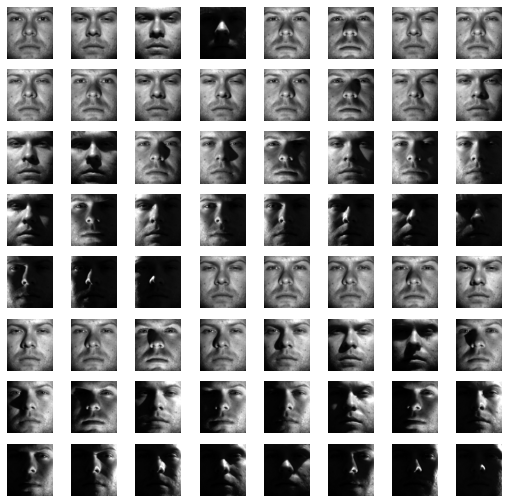

In [5]:
for counter in range(number_of_faces_per_person[0]):
    plt.subplot(8, 8, counter + 1)
    plt.imshow(matrix[:, counter].reshape((168, 192)).T, cmap='gray')
    plt.axis('off') 
plt.tight_layout;

We write two functions **soft_thresholding** and **sparse_pca**. The function **soft_thresholding** is implementing the soft-thresholding operation

$$ \left( \left(I + \gamma \partial \| \cdot \|_1 \right)^{-1}(z) \right)_j = \begin{cases} z_j - \gamma & z > \gamma \\ 0 & |z_j | \leq \gamma \\ z_j + \gamma & z_j < - \gamma \end{cases} \, . $$

The function **sparse_pca** takes the arguments described in the function header and returns the solution of

\begin{align*}
    w^{k + 1} &= \arg\min_{w \in \mathbb{R}^n} \left\{ \alpha \| w \|_1 - \lambda^k \frac{\langle X^\top u^k, X^\top w\rangle}{\| X^\top w^k\|} + \frac{1}{2\tau} \| w - u^k \|^2 \right\} \, ,\label{eq:ipm-sparse-pca}\\
    u^{k + 1} &= \frac{w^{k + 1}}{\| w^{k + 1} \|_p} \, ,\\
    \lambda^{k + 1} &= \frac{\alpha \| u^{k + 1} \|_1}{\| X^\top u^{k + 1} \|} \, .
\end{align*}

after *maximum_no_of_iterations* iterations. Here, the step size parameter $\tau$ is named *step_size*, the balancing parameter $\alpha$ *regularisation_parameter* and the value $p$ for the $p$-norm is *p_norm*. The matrix $X$ is the mathematical notation for the variable *data_matrix*. Implement **sparse_pca** so that it returns the final singular vector and a list of singular values over the course of the iteration.

In [6]:
def soft_thresholding(argument, threshold):
    return np.sign(argument) * np.maximum(0, np.abs(argument) - threshold)

def sparse_pca(data_matrix, initial_vector, step_size=0.1, regularisation_parameter=1.635, p_norm=2, \
                maximum_no_of_iterations=100, print_output=10):
    w0 = initial_vector
    u0 = initial_vector/np.linalg.norm(initial_vector,ord = p_norm)
    l0 = regularisation_parameter*np.linalg.norm(u0,1)/np.linalg.norm(data_matrix.T@u0,2)
    singular_values = [l0]
    count = 0

    while count < maximum_no_of_iterations :
        if (count%print_output) == 0:
            print("singular value",count,"= ", l0)
            
        weight = u0+(step_size*l0*regularisation_parameter)*(data_matrix@(data_matrix.T@u0))/np.linalg.norm(data_matrix.T@u0,2)
        w0 = soft_thresholding(weight,regularisation_parameter*step_size)
        u0 = w0/np.linalg.norm(w0,p_norm)
        l0 = regularisation_parameter*np.linalg.norm(u0,1)/np.linalg.norm(data_matrix.T@u0,2)
        
        count+=1
        singular_values.append(l0)
    return u0,singular_values

We initialise a vector with normal distributed random numbers with mean zero and standard deviation one and normalise it with respect to the Euclidean norm.

In [15]:
np.random.seed(13)
p = 2
initial_vector = np.random.randn(matrix.shape[0], 1)
initial_vector = initial_vector / np.linalg.norm(initial_vector, p)

We compute a sparse singular vector for the data matrix *matrix*, the initial vector *initial_vector* and the value *p* for *p_norm*. Store the singular vector in a variable named *singular_vector* and the list of singular values in a variable named *singular_values*.

In [8]:
singular_vector, singular_values = sparse_pca(matrix,initial_vector)

singular value 0 =  3.457319962765312
singular value 10 =  0.04088544602042678
singular value 20 =  0.04088178156419741
singular value 30 =  0.040881056013388484
singular value 40 =  0.04088088248287352
singular value 50 =  0.040880841174749646
singular value 60 =  0.04088083134106932
singular value 70 =  0.040880829003749196
singular value 80 =  0.04088082844727028
singular value 90 =  0.04088082831476832


We want to visualise this singular vector and compare it to the first traditional singular vector. For this, you can use your code from Coursework 6 to obtain the matrix U: 

In [9]:
U, singvals, Vt = np.linalg.svd(matrix)

..and now we visualise and compare the two singular vectors with the following cell: 

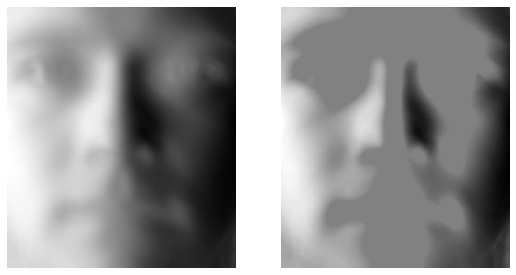

In [10]:
plt.subplot(1,2,1)
plt.imshow(U[:, 0].reshape((168, 192)).T, cmap='gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(singular_vector.reshape((168, 192)).T, cmap='gray')
plt.axis('off');

We further plot the singular vector and determine how many percent of entries are non-zero.

Around 59.19 % of coefficients are non-zero.


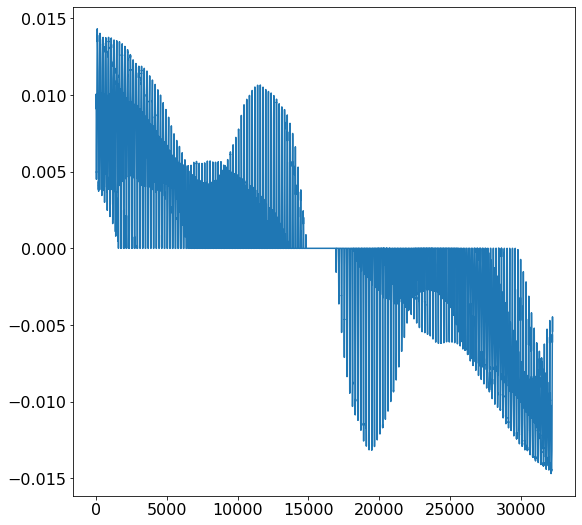

In [11]:
plt.plot(singular_vector)
print("Around {:.2f} % of coefficients are non-zero.".format(100*np.count_nonzero(singular_vector)/len( \
                                                                singular_vector)))

Test your code with the following test.

In [22]:
p = 2
initial_test_vector = np.array([1, -1, 1, -1, 1]).astype(np.float64).reshape(-1, 1)
test_matrix = np.random.randint(-5, 5, size=(5, 10))
initial_test_vector = initial_test_vector / np.linalg.norm(initial_test_vector, p)
test_singular_vector, _ = sparse_pca(test_matrix, initial_test_vector, step_size=0.04, \
                                     regularisation_parameter=0.3, p_norm=p)
assert_array_almost_equal(test_singular_vector, np.array([[0.46303975], [-0.1367626], [0.4336254], [0], \
                                                          [0.76082797]]))

singular value 0 =  0.0521286035142687
singular value 10 =  0.051252300383712514
singular value 20 =  0.050166887602118064
singular value 30 =  0.04882374276739209
singular value 40 =  0.04716289595557618
singular value 50 =  0.04510888106012732
singular value 60 =  0.04256292571262958
singular value 70 =  0.04013838973873087
singular value 80 =  0.03941212389267423
singular value 90 =  0.038457621767211195
